In [28]:
# Install keras-tuner before importing it
!pip install -q keras-tuner

import numpy as np
import pandas as pd
import scipy.io
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt  # <- corrected import
import matplotlib.pyplot as plt

In [29]:
# 1. Load and Preprocess the Data
train = pd.read_excel('Train.xlsx')
test = pd.read_excel('Test.xlsx')

In [30]:
train.head()

,K,m,b,Fr,Q,S
0,5.310000,4.048927e-10,0.000003,18218.353413,16.984067,22.478238
1,5.231140,4.117758e-10,0.000003,17929.139481,15.419598,21.747596
2,5.153834,4.186589e-10,0.000003,17647.388748,14.061505,21.049414
3,5.078043,4.255419e-10,0.000004,17372.783254,12.874915,20.381707
4,5.003732,4.324250e-10,0.000004,17105.021155,11.832038,19.742638


In [31]:
test.isnull().sum()

,0
K,0
m,0
b,0
Fr,18
Q,0
S,18


In [32]:
train.shape, test.shape

((7465, 6), (1866, 6))

In [33]:
# 2. Data Cleaning
train = train.dropna()
test = test.dropna()

In [34]:
train.head()

,K,m,b,Fr,Q,S
0,5.310000,4.048927e-10,0.000003,18218.353413,16.984067,22.478238
1,5.231140,4.117758e-10,0.000003,17929.139481,15.419598,21.747596
2,5.153834,4.186589e-10,0.000003,17647.388748,14.061505,21.049414
3,5.078043,4.255419e-10,0.000004,17372.783254,12.874915,20.381707
4,5.003732,4.324250e-10,0.000004,17105.021155,11.832038,19.742638


In [35]:
train = train.rename(columns = {"K":"k"})
test = test.rename(columns = {"K":"k"})
train.head()

,k,m,b,Fr,Q,S
0,5.310000,4.048927e-10,0.000003,18218.353413,16.984067,22.478238
1,5.231140,4.117758e-10,0.000003,17929.139481,15.419598,21.747596
2,5.153834,4.186589e-10,0.000003,17647.388748,14.061505,21.049414
3,5.078043,4.255419e-10,0.000004,17372.783254,12.874915,20.381707
4,5.003732,4.324250e-10,0.000004,17105.021155,11.832038,19.742638


In [36]:
train.head()

,k,m,b,Fr,Q,S
0,5.310000,4.048927e-10,0.000003,18218.353413,16.984067,22.478238
1,5.231140,4.117758e-10,0.000003,17929.139481,15.419598,21.747596
2,5.153834,4.186589e-10,0.000003,17647.388748,14.061505,21.049414
3,5.078043,4.255419e-10,0.000004,17372.783254,12.874915,20.381707
4,5.003732,4.324250e-10,0.000004,17105.021155,11.832038,19.742638


In [37]:
train.to_csv("train.csv")
test.to_csv("test.csv")

In [38]:
features = ['k', 'm', 'b']
target2 = 'Q'

In [39]:
# Remove outliers using z-score thresholding
z_threshold = 3
z_scores_train = np.abs(zscore(train[features]))
train_data = train[(z_scores_train < z_threshold).all(axis=1)]

z_scores_test = np.abs(zscore(test[features]))
test_data = test[(z_scores_test < z_threshold).all(axis=1)]

In [40]:
# Smooth data using a moving average filter
window_size = 10
train_data[features] = train_data[features].rolling(window=window_size, min_periods=1).mean()
test_data[features] = test_data[features].rolling(window=window_size, min_periods=1).mean()
train_data[target2] = train_data[target2].rolling(window=window_size, min_periods=1).mean()
test_data[target2] = test_data[target2].rolling(window=window_size, min_periods=1).mean()

<ipython-input-40-208a9ffdd254>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features] = train_data[features].rolling(window=window_size, min_periods=1).mean()
<ipython-input-40-208a9ffdd254>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[features] = test_data[features].rolling(window=window_size, min_periods=1).mean()
<ipython-input-40-208a9ffdd254>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [41]:
# 3. Compute Additional Features
window_size_avg = 5
train_data['Avg_k'] = train_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
train_data['Avg_m'] = train_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
train_data['Avg_b'] = train_data['b'].rolling(window=window_size_avg, min_periods=1).mean()

test_data['Avg_k'] = test_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
test_data['Avg_m'] = test_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
test_data['Avg_b'] = test_data['b'].rolling(window=window_size_avg, min_periods=1).mean()

<ipython-input-41-50d0a94bfefd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Avg_k'] = train_data['k'].rolling(window=window_size_avg, min_periods=1).mean()
<ipython-input-41-50d0a94bfefd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Avg_m'] = train_data['m'].rolling(window=window_size_avg, min_periods=1).mean()
<ipython-input-41-50d0a94bfefd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [42]:
features += ['Avg_k', 'Avg_m', 'Avg_b']


In [43]:
# 4. Normalize/Scale the Data
scaler = MinMaxScaler()

train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])
train_data[[target2]] = scaler.fit_transform(train_data[[target2]])
test_data[[target2]] = scaler.transform(test_data[[target2]])

<ipython-input-43-85f9f6b6221d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features] = scaler.fit_transform(train_data[features])
<ipython-input-43-85f9f6b6221d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[features] = scaler.transform(test_data[features])
<ipython-input-43-85f9f6b6221d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [44]:
# 5. Create Sequences for LSTM
def create_sequences(data, feature_cols, target_col, seq_len):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[feature_cols].iloc[i:i+seq_len].values)
        Y.append(data[target_col].iloc[i+seq_len])
    return np.array(X), np.array(Y)

seq_length = 200
X_train, y_train = create_sequences(train_data, features, target2, seq_length)
X_test, y_test = create_sequences(test_data, features, target2, seq_length)

In [45]:
# 6. Hyperparameter Optimization via Keras Tuner (Bayesian Optimization)
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=10, max_value=100, step=10),
                   return_sequences=True, input_shape=(seq_length, len(features))))
    model.add(LSTM(units=hp.Int('units2', min_value=5, max_value=50, step=5)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='log')),
                  loss='mse')
    return model

In [46]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=3,
    directory='kt_dir',
    project_name='lstm_tuning'
)

Reloading Tuner from kt_dir/lstm_tuning/tuner0.json


In [47]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)
best_hps = tuner.get_best_hyperparameters()[0]

print(f'Optimal Learning Rate: {best_hps.get("learning_rate")}')
print(f'Optimal Hidden Units 1: {best_hps.get("units1")}')
print(f'Optimal Hidden Units 2: {best_hps.get("units2")}')

Optimal Learning Rate: 0.0033456666176520395
Optimal Hidden Units 1: 100
Optimal Hidden Units 2: 5


In [48]:
# 7. Final Training Using Best Hyperparameters
final_model = tuner.hypermodel.build(best_hps)
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = final_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 130s 439ms/step - loss: 0.0106 - val_loss: 7.5337e-04
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 292ms/step - loss: 0.0010 - val_loss: 8.3209e-04
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 84s 299ms/step - loss: 5.1371e-04 - val_loss: 2.3752e-04
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 241ms/step - loss: 3.2341e-04 - val_loss: 7.8742e-04
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 95s 297ms/step - loss: 3.0246e-04 - val_loss: 3.1967e-04
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 217ms/step - loss: 2.2547e-04 - val_loss: 2.5009e-04
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 93s 269ms/step - loss: 2.1613e-04 - val_loss: 2.0395e-04
Epoch 8/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 77s 242ms/step - loss: 1.7784e-04 - val_loss: 2.0512e-04
Epoch 9/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 53s 241ms/step - loss: 1.4167e-04 - val_loss: 1.7071e-04
Epoch 10/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 49s 221ms/step - loss: 1.7088e-04 - val_loss: 1.0713e-04
Epoch 11/50
220/220 ━━━━━━━━━━━━━━━━

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
Test RMSE: 1.3812%
Test MAE: 0.8562%
Test MAX: 8.9654%


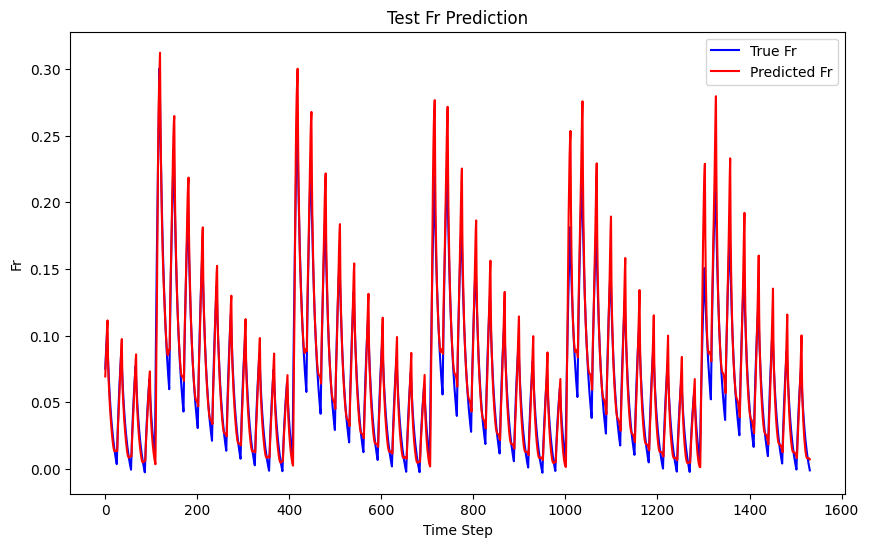

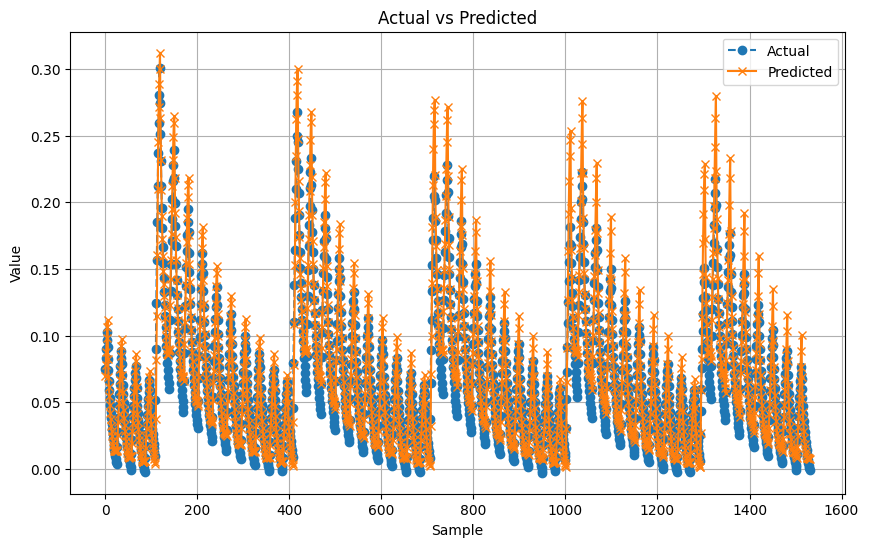

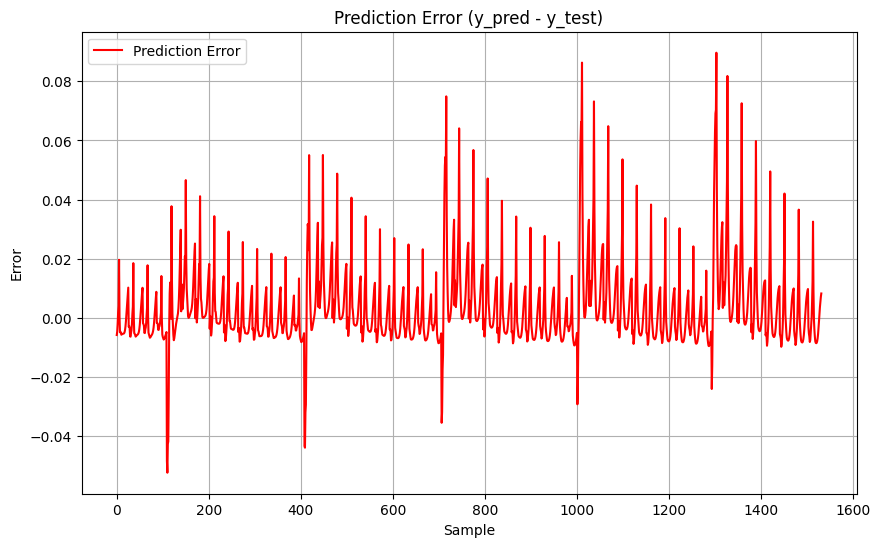

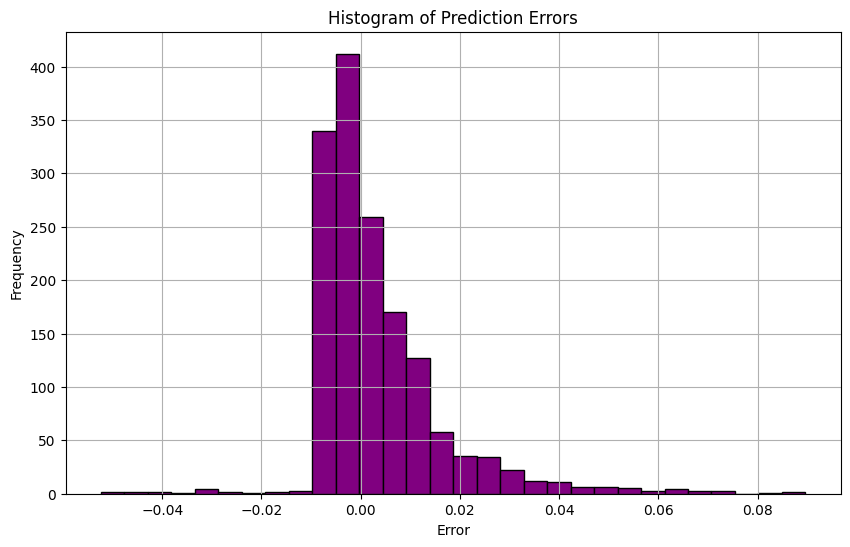

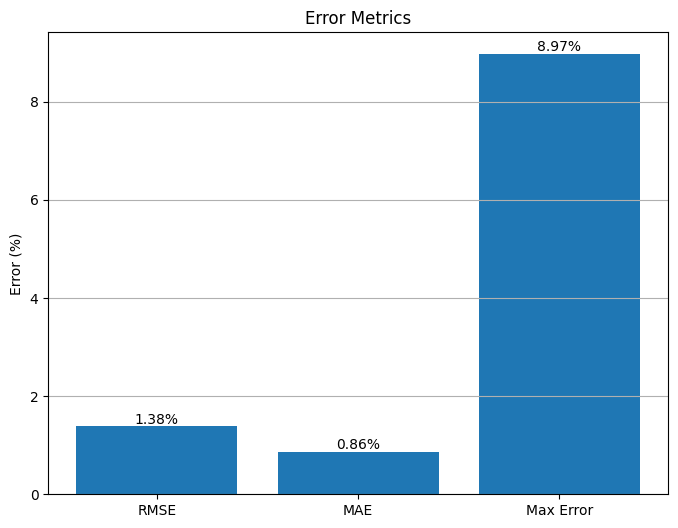

Root Mean Squared Error (RMSE): 2.3238
Mean Absolute Error (MAE): 2.2000
Max Absolute Error: 3.0000
Mean Error (Bias): 0.2000
Standard Deviation of Errors: 2.3152
Median Absolute Error: 2.0000
R-squared Score: 0.9730
Mean Absolute Percentage Error (MAPE): 9.90%


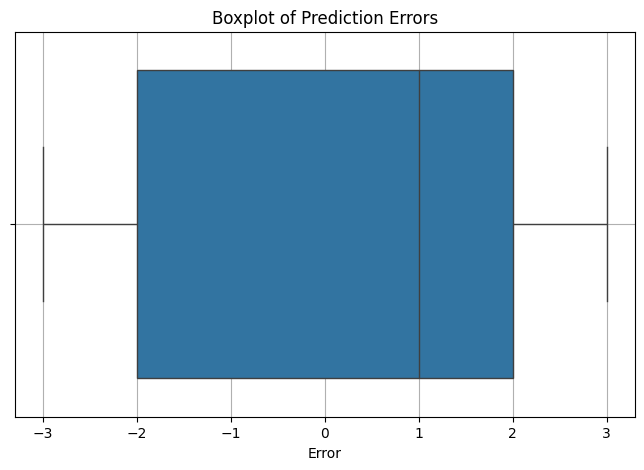

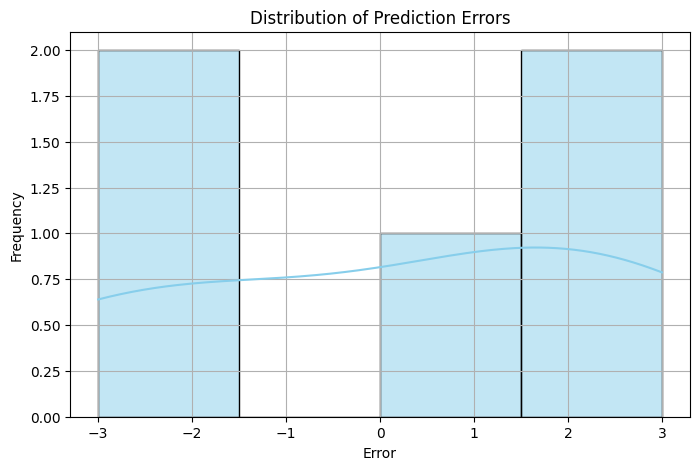

In [49]:
# 8. Evaluate the Model
N = 50
NN = 50

y_pred = final_model.predict(X_test, batch_size=32).flatten()

y_pred_trim = y_pred[N:len(y_pred)-NN]
y_test_trim = y_test[N:len(y_test)-NN]

error_test = y_pred_trim - y_test_trim
rmse = np.sqrt(np.mean(error_test ** 2)) * 100
mae = np.mean(np.abs(error_test)) * 100
max_error = np.max(np.abs(error_test)) * 100

print(f'Test RMSE: {rmse:.4f}%')
print(f'Test MAE: {mae:.4f}%')
print(f'Test MAX: {max_error:.4f}%')

# 9. Plot 1: Predictions in the Time Domain
plt.figure(figsize=(10, 6))
plt.plot(y_test_trim, 'b', linewidth=1.5, label='True Q')
plt.plot(y_pred_trim, 'r', linewidth=1.5, label='Predicted Q')
plt.xlabel('Time Step')
plt.ylabel('Q')
plt.title('Test Q Prediction')
plt.legend()
plt.show()

# Plot 2: Predicted vs Actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_trim, label='Actual', marker='o', linestyle='--')
plt.plot(y_pred_trim, label='Predicted', marker='x', linestyle='-')
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Error over samples
plt.figure(figsize=(10, 6))
plt.plot(error_test, label='Prediction Error', color='red')
plt.title('Prediction Error (y_pred - y_test)')
plt.xlabel('Sample')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Plot 4: Histogram of errors
plt.figure(figsize=(10, 6))
plt.hist(error_test, bins=30, color='purple', edgecolor='black')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Quality Factor')
plt.grid(True)
plt.show()

# Plot 5: Bar Chart of Error Metrics
error_metrics = ['RMSE', 'MAE', 'Max Error']
values = [rmse, mae, max_error]

plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, values)
plt.title('Error Metrics')
plt.ylabel('Error (%)')

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', ha='center', va='bottom')

plt.grid(axis='y')
plt.show()


import numpy as np
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error

# Example data (replace with your data)
test_Y = np.array([10, 20, 30, 40, 50])      # Actual values
predictions = np.array([12, 18, 33, 37, 49])  # Predicted values

# Compute errors
errors = test_Y - predictions

# Basic Error Metrics
rmse = np.sqrt(np.mean(errors ** 2))
mae = np.mean(np.abs(errors))
max_error = np.max(np.abs(errors))

# Additional Statistical Metrics
mean_error = np.mean(errors)  # Bias
std_error = np.std(errors)    # Standard deviation of errors
median_abs_error = median_absolute_error(test_Y, predictions)  # Robust to outliers
r_squared = r2_score(test_Y, predictions)  # Goodness of fit
mape = mean_absolute_percentage_error(test_Y, predictions) * 100  # In percentage

# Display results
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Max Absolute Error: {max_error:.4f}")
print(f"Mean Error (Bias): {mean_error:.4f}")
print(f"Standard Deviation of Errors: {std_error:.4f}")
print(f"Median Absolute Error: {median_abs_error:.4f}")
print(f"R-squared Score: {r_squared:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of errors
plt.figure(figsize=(8, 5))
sns.boxplot(x=errors)
plt.title('Boxplot of Prediction Errors')
plt.xlabel('Error')
plt.grid(True)
plt.show()

# Distribution (KDE) plot of errors
plt.figure(figsize=(8, 5))
sns.histplot(errors, kde=True, color='skyblue')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Quality Factor')
plt.grid(True)
plt.show()
